In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='white', palette='Dark2', font_scale=0.8)

In [2]:
# Loading the data

In [3]:
file_ = './main_table_of_Fourches_ligs_ERK2.pkl'
with open(file_, 'rb') as f:
    df_erk2_mols = pickle.load(f)
df_erk2_mols = df_erk2_mols.set_index('Name')
df_erk2_mols = df_erk2_mols.sort_values('pKi', ascending = False)

RDKit WARNING: [15:39:26] Enabling RDKit 2019.09.1 jupyter extensions


In [4]:
# Get the names of each one of the precomputed descriptors

In [5]:
# WHIM

In [6]:
# List of RDKit descriptors

whim_axial = [ "L1u", "L2u", "L3u", "P1u", "P2u", "G1u", "G2u", "G3u", "E1u", "E2u", "E3u", 
               "L1m", "L2m", "L3m", "P1m", "P2m", "G1m", "G2m", "G3m", "E1m", "E2m", "E3m", 
               "L1v", "L2v", "L3v", "P1v", "P2v", "G1v", "G2v", "G3v", "E1v", "E2v", "E3v", 
               "L1e", "L2e", "L3e", "P1e", "P2e", "G1e", "G2e", "G3e", "E1e", "E2e", "E3e", 
               "L1p", "L2p", "L3p", "P1p", "P2p", "G1p", "G2p", "G3p", "E1p", "E2p", "E3p", 
               "L1i", "L2i", "L3i", "P1i", "P2i", "G1i", "G2i", "G3i", "E1i", "E2i", "E3i", 
               "L1s", "L2s", "L3s", "P1s", "P2s", "G1s", "G2s", "G3s", "E1s", "E2s", "E3s"]
whim_global = ["Tu", "Tm", "Tv", "Te", "Tp", "Ti", "Ts", 
               "Au", "Am", "Av", "Ae", "Ap", "Ai", "As", 
               "Gu", "Gm", 
               "Ku", "Km", "Kv", "Ke", "Kp", "Ki", "Ks", 
               "Du", "Dm", "Dv", "De", "Dp", "Di", "Ds", 
               "Vu", "Vm", "Vv", "Ve", "Vp", "Vi", "Vs"]

rdkit_whim_names = whim_axial + whim_global

In [7]:
# USR - 3dMOMENTS

In [8]:
rdkit_USR_names = ['Ctd-Mean', 'Ctd-Sigma', 'Ctd-Skewness', 'Cst-Mean', 'Cst-Sigma',
                   'Cst-Skewness', 'Fct-Mean', 'Fct-Sigma', 'Fct-Skewness', 'Ftf-Mean',
                   'Ftf-Sigma', 'Ftf-Skewness']

In [9]:
# Extract the set of descriptors from the main data table

In [10]:
# First extract WHIM

In [11]:
# First, add the means
d_mean = df_erk2_mols['whim_3d_ESNDK_mean'].map(lambda x: list(map(np.float, x)))
df_whim_mean = pd.DataFrame.from_dict(dict(zip(d_mean.index, d_mean.values))).T
df_whim_mean.columns = [name + '_mean' for name in rdkit_whim_names]

# Second, add the standard deviations
d_std = df_erk2_mols['whim_3d_ESNDK_std'].map(lambda x: list(map(np.float, x)))
df_whim_std = pd.DataFrame.from_dict(dict(zip(d_std.index, d_std.values))).T
df_whim_std.columns = [name + '_std' for name in rdkit_whim_names]

# Concat columns
df_whim_all = pd.concat([df_whim_mean, df_whim_std], axis=1)

In [12]:
# Then, extract USR

In [13]:
# First, add the means
d_mean = df_erk2_mols['dMoments_3d_ESNDK_mean'].map(lambda x: list(map(np.float, x)))
df_usr_mean = pd.DataFrame.from_dict(dict(zip(d_mean.index, d_mean.values))).T
df_usr_mean.columns = [name + '_mean' for name in rdkit_USR_names]

# Second, add the standard deviations
d_std = df_erk2_mols['dMoments_3d_ESNDK_std'].map(lambda x: list(map(np.float, x)))
df_usr_std = pd.DataFrame.from_dict(dict(zip(d_std.index, d_std.values))).T
df_usr_std.columns = [name + '_std' for name in rdkit_USR_names]

# Concat columns
df_usr_all = pd.concat([df_usr_mean, df_usr_std], axis=1)

In [14]:
# Concat the columns of both datafames
df_3d_all = pd.concat([df_whim_all, df_usr_all], axis=1)
df_3d_all.shape

(87, 252)

In [15]:
df_3d_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, CSAR_erk2_18 to erk2_01
Columns: 252 entries, L1u_mean to Ftf-Skewness_std
dtypes: float64(252)
memory usage: 172.0+ KB


In [16]:
### PCA

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

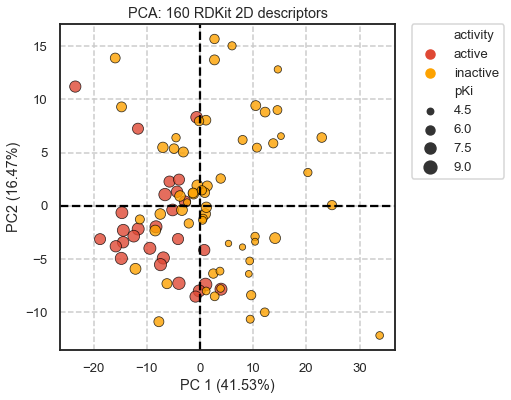

In [18]:
# Pipeline
scaler = StandardScaler()
pca = PCA(n_components=2)
pca_pipe = Pipeline(steps = [('scaler', scaler), ('pca', pca)])

X_3d = df_3d_all
pca_pipe.fit(X_3d)
# Components
components = pca_pipe.transform(X_3d).T
# Variance ratio
var_ = (pca_pipe['pca'].explained_variance_ratio_ * 100).round(2)

df_pca = df_erk2_mols[['activity', 'pKi']].copy()
df_pca['activity'] = ['active' if i else 'inactive' for i in df_pca.activity]
df_pca['pc1'] = components[0]
df_pca['pc2'] = components[1]

# Plot the PCS
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvline(linestyle='--', color='k')
ax.axhline(linestyle='--', color='k')
sns.scatterplot(x='pc1', y='pc2', hue='activity', size='pKi', data=df_pca, 
                ax=ax, palette=['#df4834', '#fda200'], edgecolor='k', alpha=0.8)
ax.set(title='PCA: 160 RDKit 2D descriptors',
      xlabel=f'PC 1 ({var_[0]}%)', ylabel=f'PC2 ({var_[1]}%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='--')
plt.show()

In [19]:
## Feature Selection

In [20]:
### Variance Threshold

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
# first scale the variables using min_max scaler
min_max_scaler = MinMaxScaler()

X_3d_minmax = min_max_scaler.fit_transform(X_3d)
variances = X_3d_minmax.var(axis=0)
# Get the value of the first quartile
q1 = np.quantile(variances, 0.25)
# Variance filter
variance_filter = variances > q1
# Apply the filter
X_3d_var = X_3d.loc[:, variance_filter]

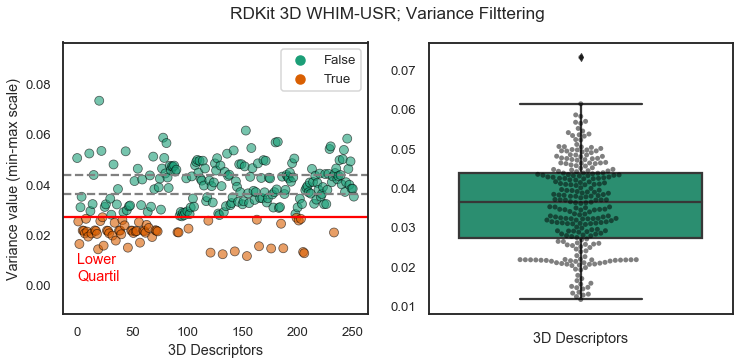

63 features were dropped.


In [23]:
# Plot variances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('RDKit 3D WHIM-USR; Variance Filttering')
q1, q2, q3 = np.quantile(variances, [0.25, 0.5, 0.75])
n_descriptors = X_3d.shape[1]

ax1 = sns.scatterplot(x=range(0, n_descriptors), 
                      y=variances, ax=ax1, hue=(variances < q1),
                      edgecolor='k', alpha = 0.6)
ax1.set(xlabel='3D Descriptors', ylabel='Variance value (min-max scale)')
ax1.annotate('Lower\nQuartil', xy=(0, q1-.025), color='red')
ax1.axhline(q1, color='red')
ax1.axhline(q2, color='grey', linestyle='--')
ax1.axhline(q3, color='grey', linestyle='--')

ax2 = sns.boxplot(y=variances, ax=ax2)
ax2 = sns.swarmplot(y=variances, ax=ax2, color='black', alpha=0.5)
ax2.set(xlabel='3D Descriptors')
plt.show()

print(sum(variances <= q1), 'features were dropped.')

In [24]:
## Z-score Standarization

In [25]:
# Standarization
scaler = StandardScaler()
X_3d_std = pd.DataFrame(scaler.fit_transform(X_3d_var), columns=X_3d_var.columns, index=X_3d_var.index)
X_3d_std.shape

(87, 189)

In [26]:
## Correlation filtering (Pearson correlation coefficient)

#### Using the `caret` package

##### This time we are going to use the 'caret' package in R, the same package that Ash & Fourches used.

In [27]:
%load_ext rpy2.ipython

In [28]:
%%R -i X_3d_std -o cols_to_drop

corr_mtx = cor(X_3d_std, method='pearson')
cols_to_drop = caret::findCorrelation(corr_mtx, cutoff=0.9, exact=TRUE, names=TRUE)
cols_to_drop

  [1] "L1m_std"        "L1v_std"        "L1p_std"        "L1e_std"       
  [5] "L1u_std"        "Ctd-Sigma_std"  "Cst-Mean_mean"  "L1i_std"       
  [9] "Tm_std"         "Ai_mean"        "Ctd-Mean_mean"  "Vv_std"        
 [13] "Ae_mean"        "Vp_std"         "Au_mean"        "Vi_mean"       
 [17] "As_mean"        "Vu_std"         "Ti_mean"        "Ve_mean"       
 [21] "Ftf-Sigma_std"  "Vs_mean"        "Vu_mean"        "Te_mean"       
 [25] "Tp_std"         "Vs_std"         "Tu_mean"        "Ve_std"        
 [29] "Tv_std"         "L1s_std"        "Ts_mean"        "Vi_std"        
 [33] "Av_mean"        "Tv_mean"        "L2s_std"        "Fct-Mean_mean" 
 [37] "Te_std"         "Fct-Sigma_std"  "Vv_mean"        "Tu_std"        
 [41] "Tp_mean"        "Ftf-Mean_mean"  "L2e_std"        "Ti_std"        
 [45] "Ap_mean"        "L2u_std"        "Tm_mean"        "Vp_mean"       
 [49] "Vm_std"         "L2i_std"        "L2v_std"        "L1i_mean"      
 [53] "L1u_mean"       "L1e_mean"     

In [29]:
# Drop the identified features by caret
X_3d_corr = X_3d_std.drop(cols_to_drop, axis=1)
X_3d_corr.shape

(87, 62)

In [30]:
# Visualize correlation before and after removing features

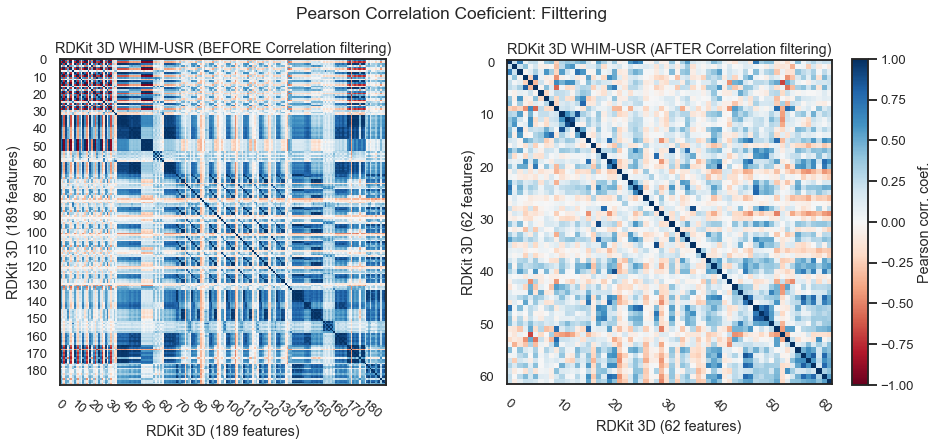

In [31]:
fig = plt.figure(figsize=(16, 6))
plt.suptitle('Pearson Correlation Coeficient: Filttering', y = 1.0)

# ALL FEATURES POST VARIANCE THR
n_init_feat = X_3d_std.shape[1]
corr_mtx_all = X_3d_std.corr(method='pearson')

plt.subplot(1, 2, 1)
plt.imshow(corr_mtx_all, cmap='RdBu', vmin=-1, vmax=1)
plt.yticks(range(0, n_init_feat, 10))
plt.xticks(range(0, n_init_feat, 10), rotation=-40)
axlabel_ = f'RDKit 3D ({n_init_feat} features)'
plt.xlabel(axlabel_); plt.ylabel(axlabel_)
plt.title('RDKit 3D WHIM-USR (BEFORE Correlation filtering)')


# FEATURES POST CORR FILTERING
n_new_feat = X_3d_corr.shape[1]
corr_mtx_post_corr = X_3d_corr.corr(method='pearson')

plt.subplot(1, 2, 2)
plt.imshow(corr_mtx_post_corr, cmap='RdBu', vmin=-1, vmax=1)
plt.yticks(range(0, n_new_feat, 10))
plt.xticks(range(0, n_new_feat, 10), rotation=-40)
axlabel_ = f'RDKit 3D ({n_new_feat} features)'
plt.xlabel(axlabel_); plt.ylabel(axlabel_)
plt.title('RDKit 3D WHIM-USR (AFTER Correlation filtering)')

cbar = plt.colorbar()
cbar.set_label('Pearson corr. coef.')
plt.show()

In [32]:
# Pearson Correlation of 68 descriptors with pKi values

In [33]:
from scipy.stats import pearsonr, spearmanr

In [34]:
rd3d_corr_values_with_pki = [pearsonr(desc, df_erk2_mols.pKi) for i, desc in X_3d_corr.iteritems()]

df_rd3d_corr_pki = pd.DataFrame({
          'descriptor': X_3d_corr.columns,
          'corr_pearson': [i[0] for i in rd3d_corr_values_with_pki],
          'p_value': [i[1] for i in rd3d_corr_values_with_pki],
          'significative': [i[1] < 0.05 for i in rd3d_corr_values_with_pki]
         })

In [35]:
corr_features_above_04 = df_rd3d_corr_pki[(df_rd3d_corr_pki.corr_pearson.abs() >= 0.4) & 
                           (df_rd3d_corr_pki.significative)]
corr_features_above_04.reset_index()

,index,descriptor,corr_pearson,p_value,significative
0,15,Vm_mean,0.611374,3.181241e-10,True
1,19,L2m_std,0.489955,1.460204e-06,True
2,38,E1i_std,0.411642,7.459837e-05,True
3,45,Ts_std,0.432948,2.810547e-05,True
4,46,Au_std,0.476316,3.111611e-06,True
5,50,Ds_std,0.417790,5.666325e-05,True
6,51,Ctd-Sigma_mean,0.506128,5.701178e-07,True
7,58,Fct-Mean_std,0.431478,3.012748e-05,True
8,60,Ftf-Mean_std,0.577103,4.889241e-09,True


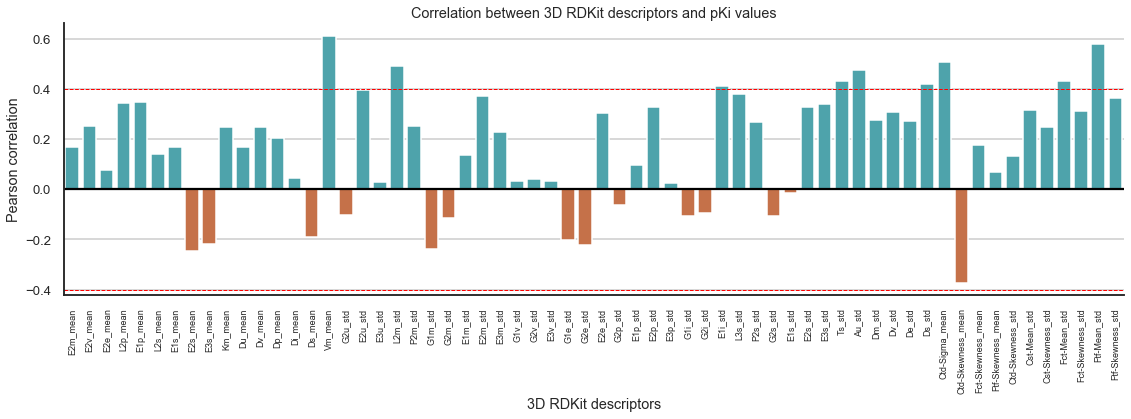

In [36]:
# plot  correlation values
color_palette = ['#3eb0ba' if i > 0 else '#da6a34' for i in df_rd3d_corr_pki.corr_pearson]
fig, ax = plt.subplots(figsize=(19, 5))

sns.barplot(x='descriptor', y = 'corr_pearson', data=df_rd3d_corr_pki, palette=color_palette, ax=ax)

ax.set_xticklabels(df_rd3d_corr_pki.descriptor, rotation=90, fontdict={'fontsize': 9})
ax.set(ylabel='Pearson correlation', xlabel='3D RDKit descriptors',
       title='Correlation between 3D RDKit descriptors and pKi values')
plt.grid(axis='y')
plt.axhline(color='k')
plt.axhline(y=0.4, linestyle='--', linewidth=1, color='red')
plt.axhline(y=-0.4, linestyle='--', linewidth=1, color='red')
sns.despine()
plt.show()

In [37]:
# Clustering

In [38]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


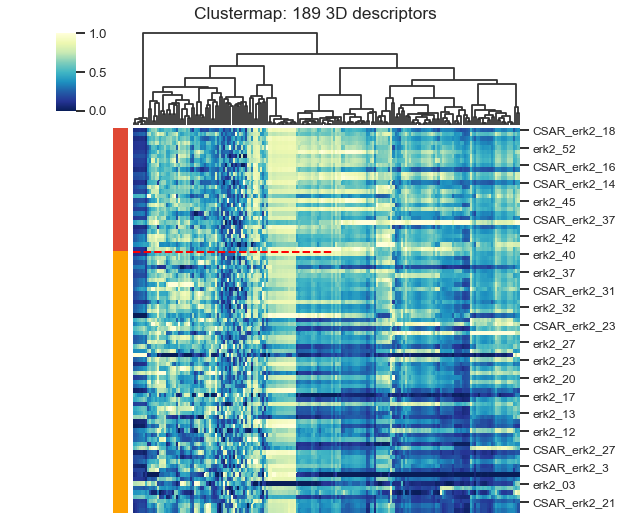

In [39]:
df = X_3d_std

dist_euc_std = ssd.pdist(df.T, 'euclidean')
dist_euc_std = ssd.squareform(dist_euc_std)
link_euc = linkage(dist_euc_std, method='average', optimal_ordering=True)

colors_rows = ['#df4834' if i >= 7.5 else '#fda200' for i in df_erk2_mols['pKi']]

clusmap = sns.clustermap(df, cmap ='YlGnBu_r',
                standard_scale=1,
                row_cluster=False,
                col_linkage=link_euc,
                row_colors=colors_rows,
                cbar_pos=(0.1, .85, .03, .12),
                tree_kws={'linewidth': 1.8},
                figsize=(9, 9)
              )

# Number of actives
n_features = df.shape[1]
n_actives = sum(df_erk2_mols['pKi'] >= 7.5)
ax = clusmap.ax_heatmap
ax.set_yticklabels(clusmap.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
ax.hlines(y=n_actives, xmin=0, xmax=97, linewidth=2, linestyle='--', color = 'r')
clusmap.fig.suptitle(f'Clustermap: {n_features} 3D descriptors', y=1.01) 
ax.tick_params(labelbottom=False)
plt.show()

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  after removing the cwd from sys.path.


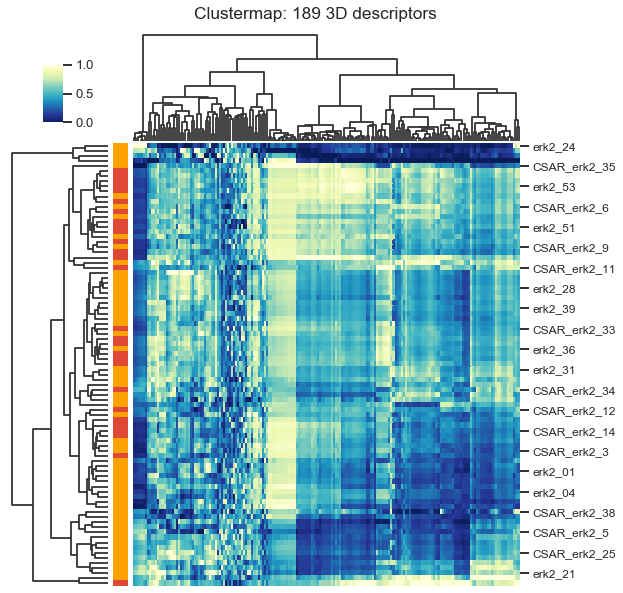

In [40]:
df = X_3d_std

dist_euc_rows = ssd.pdist(df, 'euclidean')
link_euc_rows = linkage(ssd.squareform(dist_euc_rows), method='average', optimal_ordering=True)

clusmap = sns.clustermap(df, cmap ='YlGnBu_r',
                standard_scale=1,
                row_linkage=link_euc_rows,
                col_linkage=link_euc,
                col_cluster=True,
                row_colors=colors_rows,
                cbar_pos=(0.08, .85, .03, .08),
                tree_kws={'linewidth': 1.8},
                figsize=(9, 10)
              )

ax = clusmap.ax_heatmap
ax.set_xticklabels(clusmap.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(clusmap.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
clusmap.fig.suptitle(f'Clustermap: {n_features} 3D descriptors', y=1.01) 
ax.tick_params(labelbottom=False)
plt.show()

In [41]:
## Paired t-test to compare Actives against Inactives

#### Supplementary Table S3

# First, let's inspect the Table S3 from Ash & Fourches (2017), and count how many 2D descriptors they report as significative.

In [42]:
# Comparing Actives against inactives given a descriptor's space

In [43]:
from scipy.stats import levene
from statsmodels.stats.weightstats import ttest_ind

In [44]:
def calc_cohens_D(sample_a, sample_b, equal_var = True, ddof = 1):
    # Get the  sample means
    m_a = np.mean(sample_a)
    m_b = np.mean(sample_b)
    diff_m = abs(m_a - m_b)
    # If equal var
    if equal_var:
        n_a = len(sample_a)
        n_b = len(sample_b)
        pool_std = np.sqrt( ((n_a - ddof)*np.var(sample_a, ddof=ddof) + 
                             (n_b - ddof)*np.var(sample_b, ddof=ddof)) / (n_a + n_b - 2))
    else:
        pool_std = np.sqrt( (np.var(sample_a, ddof=ddof) + np.var(sample_b, ddof=ddof)) / 2)
    cohen_d = diff_m / pool_std
    # Determine the size effect
    effect_size = 'small' if cohen_d <= 0.2 else 'medium' if cohen_d <= 0.5 else 'large'
    return cohen_d, effect_size

In [45]:
def calc_t_and_D_statistics(df, activity_array):
    '''
        df: A pandas tidy dataframe
        activity_array: a numpy array or pandas series with boolen values
    '''
    #Divide the main dataframe (after corr filtering) in two samples

    df_actives = df[activity_array == True]
    df_inactives = df[activity_array == False]

    # Create an empty dataframe])
    df_results = pd.DataFrame()

    # Iterate over all features
    for feature in df.columns:
        # Split the descriptor values bu molecules activity
        active_values = df_actives[feature]
        inactive_values = df_inactives[feature]

        #******* HOMOCEDASTICITY *******
        # Compute Levene test for homocedaticity
        w_statistic, l_p_value = levene(inactive_values, active_values,
                                      center='mean')
        if l_p_value > 0.05:
            homo_var = 'pooled' # H0 accepted, equal variances
            homocedastic = True
        else:
            homo_var = 'unequal'
            homocedastic = False

        # ******* t-TEST *********
        # compute the t-test
        t_statistic, t_pvalue, ddof = ttest_ind(inactive_values, active_values,
                                         alternative = 'two-sided',
                                         usevar = homo_var)

        # ******* Cohen's D value ******
        cohens_d, effect_size = calc_cohens_D(inactive_values, active_values, 
                                 equal_var = homocedastic) 
        # Append the results to the dataframe
        df_results = df_results.append({'Descriptor': feature, 
                           'levene_p_value': l_p_value, 'homocedastic': homocedastic, 
                           't_statistic': t_statistic, 't_p_value': t_pvalue,
                           'cohens_d_value':cohens_d, 'cohens_effect': effect_size},
                           ignore_index = True)

    df_results = df_results.set_index('Descriptor')
    df_results = df_results[['homocedastic', 'levene_p_value', 't_statistic',
                         't_p_value', 'cohens_d_value', 'cohens_effect']]
    df_results = df_results.sort_values(['cohens_d_value', 't_p_value'], ascending=False)
    return df_results

In [46]:
activity_array = df_erk2_mols.activity
df_3d_significance = calc_t_and_D_statistics(X_3d_corr, activity_array)

In [47]:
# Benjamin-Hechberg correction (FDR method)

In [48]:
from statsmodels.stats.multitest import multipletests

In [49]:
hb = multipletests(df_3d_significance['t_p_value'], alpha=0.05,
                   is_sorted=False, method='fdr_bh')

df_3d_significance['BH_p_value'] = hb[1]
df_3d_significance['BH_passed'] = hb[0]
df_3d_significance[df_3d_significance['BH_passed'] == True].reset_index()

,Descriptor,homocedastic,levene_p_value,t_statistic,t_p_value,cohens_d_value,cohens_effect,BH_p_value,BH_passed
0,Vm_mean,1.0,0.183493,-7.089029,3.708904e-10,1.626827,large,2.299520e-08,True
1,Ctd-Sigma_mean,1.0,0.121892,-5.782099,1.192543e-07,1.326906,large,3.696884e-06,True
2,L2m_std,1.0,0.936492,-4.987912,3.193096e-06,1.144652,large,5.770425e-05,True
3,Au_std,1.0,0.646951,-4.949468,3.722855e-06,1.135829,large,5.770425e-05,True
4,Ftf-Mean_std,0.0,0.038823,-4.491784,2.558770e-05,0.962553,large,3.172874e-04,True
5,E2s_mean,0.0,0.041928,4.144991,8.618320e-05,0.877534,large,8.905597e-04,True
6,E3s_std,0.0,0.042609,-3.651676,4.807004e-04,0.780327,large,3.725428e-03,True
7,E1i_std,1.0,0.056886,-3.387780,1.069553e-03,0.777445,large,6.631226e-03,True
8,Ftf-Skewness_std,0.0,0.000157,-3.890962,1.999386e-04,0.769970,large,1.770884e-03,True
9,L2p_mean,1.0,0.675409,-3.195258,1.961134e-03,0.733264,large,1.092188e-02,True


In [50]:
# Euclidian distance matrix

# Compute the euclidean distance matrix using the remaining descriptors previously standarized (z-score)

In [51]:
import scipy.spatial.distance as ssd

In [60]:
euc_3d_mtx = ssd.pdist(X_3d_corr, metric='euclidean')
euc_3d_mtx = ssd.squareform(euc_3d_mtx)

X_3d_corr.shape

(87, 62)

In [53]:
# pKi Deltas matrix

In [54]:
# Compute a matrix with the absolute Delta pKi values between each pair of molecules
n_mols = df_erk2_mols.shape[0]
pki_vector = df_erk2_mols.pKi.values
delta_pki_matrix = np.zeros((n_mols, n_mols))
for i in range(n_mols):
    for j in range(n_mols):
        deltas = np.abs(pki_vector[i] - pki_vector)
        # Fill the matrix
        delta_pki_matrix[i, :] = deltas

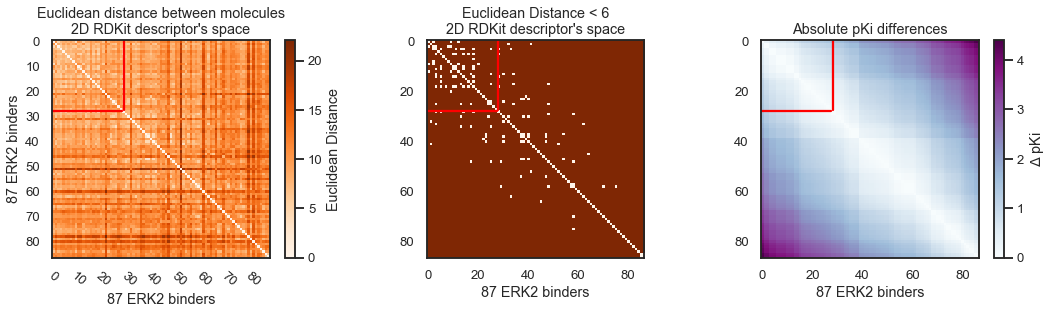

In [55]:
n_actives = df_erk2_mols.activity.sum()

fig = plt.figure(figsize=(18, 4))

plt.subplot(1,3,1)
plt.imshow(euc_3d_mtx, cmap='Oranges')
plt.yticks(range(0, n_mols, 10))
plt.xticks(range(0, n_mols, 10), rotation=-40)
xlabel_ = f'{n_mols} ERK2 binders'
plt.xlabel(xlabel_); plt.ylabel(xlabel_)
plt.title("Euclidean distance between molecules\n2D RDKit descriptor's space")

plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')

cbar1 = plt.colorbar()
cbar1.set_label('Euclidean Distance')


# Euclidean distance threshold (< 6)
plt.subplot(1,3,2)
euc_dist_threshold = euc_3d_mtx < 6
# Just for visualization fill the diagonal
plt.imshow(euc_dist_threshold, cmap='Oranges_r')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.xlabel(xlabel_)
plt.title("Euclidean Distance < 6\n2D RDKit descriptor's space")


# pKi deltas
plt.subplot(1,3,3)
# Just for visualization fill the diagonal
plt.imshow(delta_pki_matrix, cmap='BuPu')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.xlabel(xlabel_)
plt.title('Absolute pKi differences')

cbar2 = plt.colorbar()
cbar2.set_label('$\Delta$ pKi')

plt.show()

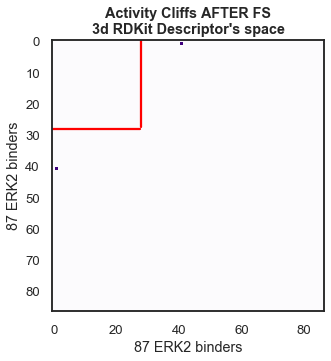

In [56]:
euclidean_mtx_dist_threshold = (euc_3d_mtx < 6) & (delta_pki_matrix > 1.5)

fig = plt.figure(figsize=(5, 5))

plt.imshow(euclidean_mtx_dist_threshold, cmap='Purples')
plt.axvline(x= n_actives, ymin= abs(n_mols - n_actives)/n_mols, ymax= n_mols, color='red')
plt.axhline(y= n_actives, xmin=0, xmax=(n_actives / n_mols), color='red')
plt.title("Activity Cliffs AFTER FS\n3d RDKit Descriptor's space", fontweight='bold')
plt.xlabel(xlabel_); plt.ylabel(xlabel_)
plt.show()

In [57]:
# Example euclidean distance

In [58]:
va = np.array([[1, 1],
               [1, 1]])

vb = np.array([[2, 2],
               [2, 2]])

np.linalg.norm(va - vb)

2.0

In [59]:
va = np.array([[1, 1],
               [1, 1],
               [1, 1]])

vb = np.array([[2, 2],
               [2, 2],
               [2, 2]])

np.linalg.norm(va - vb)

2.449489742783178